# Workshop: Access MICrONS connectomics data

The function of the nervous system arises out of a combination of the properties of individual neurons and the properties of how they are connected into a larger network. The central goal of <b>connectomics</b> is to produce complete maps of the connectivity of the nervous system with synaptic resolution and analyze them to better understand the organization, development, and function of the nervous system. 

<b>Electron Microscopy (EM) data enables morphological reconstruction of neurons and resolution of their synaptic connectivity </b>. The MICrONS dataset is one of the largest volume EM datasets currently available, and spans all layers of mouse visual cortex. We will be using this dataset to query the connectivity between neurons in the visual cortex. 

Further details about the dataset are available at [MICrONS Explorer](https://www.microns-explorer.org/), and detailed data access examples at [MICrONS Tutorials](https://tutorial.microns-explorer.org/).

For neuroglancer link, see: https://spelunker.cave-explorer.org/#!gs://microns-static-links/mm3/layer5_thick_tufted.json

<h3> Workshop aims</h3>
<ul>
    <li> Understand what are the major classes of cell types in cortex</li>
    <li> Understand the basics of how synaptic connectivity is measured in EM connectomics</li>
    <li> Look at the relationship between the structure of networks and cell type connectivity</li>
</ul>
    

<h4> This workshop will cover: </h4>
<ol> 
    <li>Reconstructions of individual neurons</li>
    <li>Connectivity of individual neurons</li>
    <li>Connectivity between cell types</li>
</ol>

## Connectome Annotation Versioning Engine (CAVE)

This tutorial walks through the key functions needed to access the MICrONS dataset programmatically and highlights key resources within it. While this tutorial is written for the MICrONS dataset specifically, the underlying technology (CAVE) is being used for multiple connectomics dataset. So, the interface presented here can be used to query them as well. 

The **CAVEclient** is a python library that facilitates communication with a CAVE system. For convenience, we also use the package **skeleton_plot** which handles rendering the precomputed skeletons.

In [1]:
# Import packages
from caveclient import CAVEclient
import skeleton_plot as skelplot

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

### CAVE account setup

In order to manage server traffic, every user needs to create a CAVE account and download a user token to access CAVE's services programmatically. The CAVE infrastructure can be read about in more detail in the [MICrONS Nature Package](https://doi.org/10.1038/s41592-024-02426-z).

**A Google account (or Google-enabled account) is required to create a CAVE account.**

Go to: https://global.daf-apis.com/auth/api/v1/user/token to view a list of your existing tokens

If you have never made a token before, accept the terms of service and generate a token. Then copy the hash string and paste below

In [ ]:
# Token Generation and Setup (Local)
CAVEclient.setup_token("https://global.daf-apis.com")

client = CAVEclient(datastack_name='minnie65_public')

In [6]:
# @title Initialize CAVE
# @markdown Requires your unique user token. Input user token

client = CAVEclient()
user_token = 'a549b45f5f69c48cf6becaba42392595' # @param {type: "string"}

try:
  client.auth.save_token(token=user_token, overwrite=True)
  # Initialize a client for the production datastack.
  client = CAVEclient(datastack_name='minnie65_public')

  cg = client.chunkedgraph
  print('Client initiation successful!')
except:
  print('Oops! Token does not work')
  print('Go to: https://global.daf-apis.com/auth/api/v1/user/token to view a list of your existing tokens')
  print('If you have never made a token before: \n  1) go here: https://minnie.microns-daf.com/materialize/views/datastack/minnie65_public to accept terms of service \n  2) then go here https://global.daf-apis.com/auth/api/v1/create_token to create a new token.')


Oops! Token does not work
Go to: https://global.daf-apis.com/auth/api/v1/user/token to view a list of your existing tokens
If you have never made a token before: 
  1) go here: https://minnie.microns-daf.com/materialize/views/datastack/minnie65_public to accept terms of service 
  2) then go here https://global.daf-apis.com/auth/api/v1/create_token to create a new token.


### Initialize CAVEclient with a datastack

Datasets in CAVE are organized as datastacks. These are a combination of an EM dataset, a segmentation and a set of annotations. The datastack for MICrONS public release is `minnie65_public`. When you instantiate your client with this datastack, it loads all relevant information to access it.

In [2]:
datastack_name = "minnie65_public"

client = CAVEclient(datastack_name, auth_token=user_token)

For each datastack, CAVE stores information about key data sources and parameters. These can be accessed through:

In [3]:
client.info.get_datastack_info()

{'aligned_volume': {'id': 1,
  'name': 'minnie65_phase3',
  'display_name': 'Minnie65',
  'description': "This is the second alignment of the IARPA 'minnie65' dataset, completed in the spring of 2020 that used the seamless approach.",
  'image_source': 'precomputed://https://bossdb-open-data.s3.amazonaws.com/iarpa_microns/minnie/minnie65/em'},
 'segmentation_source': 'graphene://https://minnie.microns-daf.com/segmentation/table/minnie65_public',
 'skeleton_source': 'precomputed://middleauth+https://minnie.microns-daf.com/skeletoncache/api/v1/minnie65_public/precomputed/skeleton/',
 'analysis_database': None,
 'viewer_site': 'https://spelunker.cave-explorer.org/',
 'synapse_table': 'synapses_pni_2',
 'soma_table': 'nucleus_detection_v0',
 'local_server': 'https://minnie.microns-daf.com',
 'description': 'This is the publicly released version of the minnie65 volume and segmentation. ',
 'viewer_resolution_x': 4.0,
 'viewer_resolution_y': 4.0,
 'viewer_resolution_z': 40.0,
 'proofreading_

For instance, the synapse table is defined as `synapses_pni_2` and the cell body table as `nucleus_detection_v0`. 

## Part 1: Neuron morphology: representing neurons as skeletons

Often in thinking about neurons, you want to measure things along a linear dimension of a neuron.

However, the segmentation and meshes are a complex 3D shape that makes this non-trivial. There are methods for reducing the shape of a segmented neuron down to a linear tree like structure usually referred to as a **skeleton**. We have precalculated skeletons for a large number of cells in the dataset, and make the skeleton generation available on our server, on demand.

*Note*: The meshes you see in Neuroglancer are available to download through the python client `cloud-volume`, and can be loaded for analysis and visualization in other tools. This is useful for some types of analysis (and for making beautiful renders of neurons), but we will not cover that in this course.

Now we will select one neuron based on its `root_id`, the 18-digit number you see in neuroglancer, for example from:  https://spelunker.cave-explorer.org/#!gs://microns-static-links/mm3/layer5_thick_tufted.json

In [4]:
# select the example cell from neuroglancer
root_id = 864691135572530981

# Query the skeleton from CAVEclient
sk_d = client.skeleton.get_skeleton(root_id, output_format="dict")

sk_d.keys() # print the keys of the skeleton dictionary object

dict_keys(['meta', 'edges', 'mesh_to_skel_map', 'root', 'vertices', 'compartment', 'radius', 'lvl2_ids'])

Now we are going to define a convenience function to plot the skeleton

In [5]:
# Color map for the different comparments. You may adjust these to your asthetic.
skel_color_map = {3: "firebrick", 4: "salmon", 2: "steelblue", 1: "olive"}


def plot_skeleton(sk_d: dict, plot_soma=True, ax=None):
    """Plots a skeleton.

    Args:
        sk: skeleton dict as returned from CAVEclient

    Returns:
        ax: plot axes
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 10), dpi=150)

    skelplot.plot_tools.plot_verts(
        np.array(sk_d["vertices"]),
        np.array(sk_d["edges"]),
        radius=np.array(sk_d["radius"]) / 1000 * 1,
        ax=ax,
        skel_colors=sk_d["compartment"],
        title="",
        skel_alpha=1.0,
        line_width=5,
        x="x",  # You can alter the projection direction by changing this to `y` or `z`
        y="y",  # You can alter the projection direction by changing this to `x` or `z`
        plot_soma=plot_soma,
        soma_node=sk_d["root"],
        color="darkslategray",
        soma_size=120,
        invert_y=True,
        skel_color_map=skel_color_map,
        x_min_max=None,
        y_min_max=None,
        capstyle="round",
        joinstyle="round",
    )

    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.axis("off")

    return ax

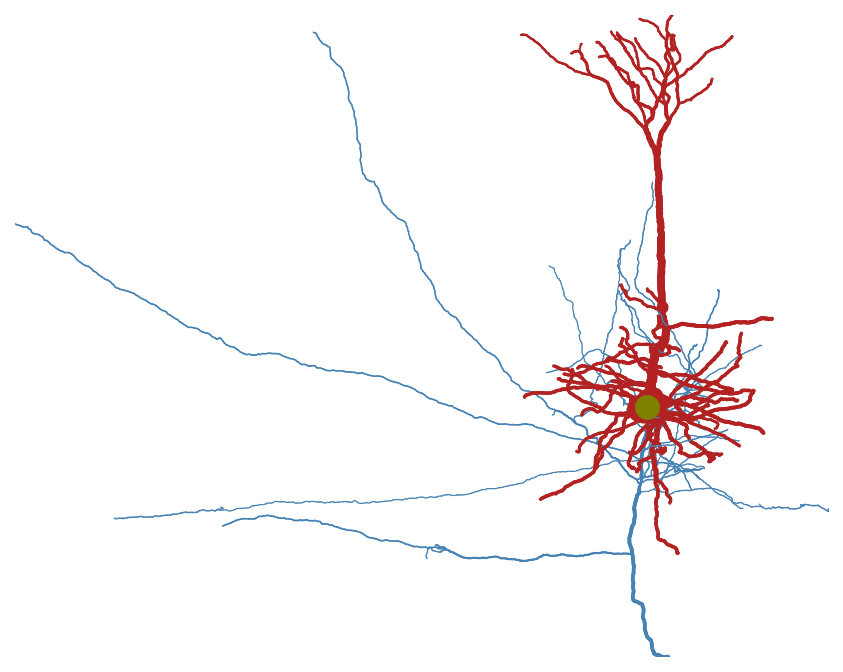

In [6]:
# Plot skeleton in 2D
ax = plot_skeleton(sk_d)
plt.show()

### Morphological compartment names 

The compartment types defined at each vertex adhere to standardized conventions for neuronal morphologies saved as swc files (for more information, see here: www.neuromorpho.org). 
    
These conventions are as follows:
<ul> 
    <li> 0 - undefined </li>
    <li> 1 - soma (default color 'olive') </li>
    <li> 2 - axon (default color 'steelblue') </li>
    <li> 3 - (basal) dendrite (default color 'firebrick' red) </li>
    <li> 4 - apical dendrite </li>
    <li> 5+ - custom </li>
</ul>

In most of these neurons, distinctions were not made between basal or apical dendrites - therefore dendrites should almost exclusively map to compartment type "3".

<b>Discussion:</b> What information do you lose going from 3D neuron meshes (neuroglancer) to 2D skeleton projections? What becomes more clear?

## Part 2: annotation tables and generally useful information

A datastack has a large number of tables that can be intimidating to traverse at first. CAVE provides several ways to find the tables you may want use.  All database functions are under the `client.materialize` property. To see what tables are available, use the `get_tables function`:

In [7]:
client.materialize.get_tables()

['baylor_gnn_cell_type_fine_model_v2',
 'nucleus_alternative_points',
 'allen_column_mtypes_v2',
 'bodor_pt_cells',
 'aibs_metamodel_mtypes_v661_v2',
 'allen_v1_column_types_slanted_ref',
 'aibs_column_nonneuronal_ref',
 'nucleus_ref_neuron_svm',
 'apl_functional_coreg_vess_fwd',
 'vortex_compartment_targets',
 'baylor_log_reg_cell_type_coarse_v1',
 'gamlin_2023_mcs',
 'l5et_column',
 'pt_synapse_targets',
 'coregistration_manual_v4',
 'cg_cell_type_calls',
 'synapses_pni_2',
 'nucleus_detection_v0',
 'vortex_manual_nodes_of_ranvier',
 'bodor_pt_target_proofread',
 'nucleus_functional_area_assignment',
 'coregistration_auto_phase3_fwd_apl_vess_combined_v2',
 'vortex_thalamic_proofreading_status',
 'multi_input_spine_predictions_ssa',
 'synapse_target_structure',
 'proofreading_status_and_strategy',
 'coregistration_auto_phase3_fwd_v2',
 'vortex_peptidergic_proofreading_status',
 'digital_twin_properties_bcm_coreg_v4',
 'vortex_astrocyte_proofreading_status',
 'digital_twin_properties_b

### Query 1: Querying cells and their types

The basic querying logic of CAVE is `client.materialize.query_table`. This accepts at least a table as parameter. Let's query the table of all automatically segmented nuclei:

In [8]:
nucleus_table_name = client.info.get_datastack_info()["soma_table"]
nucleus_df = client.materialize.query_table(nucleus_table_name)
nucleus_df.head(5)

,id,created,superceded_id,valid,volume,pt_supervoxel_id,pt_root_id,pt_position,bb_start_position,bb_end_position
0,730537,2020-09-28 22:40:41.780734+00:00,NaN,t,32.307937,0,0,"[381312, 273984, 19993]","[nan, nan, nan]","[nan, nan, nan]"
1,373879,2020-09-28 22:40:41.781788+00:00,NaN,t,229.045043,96218056992431305,864691136090135607,"[228816, 239776, 19593]","[nan, nan, nan]","[nan, nan, nan]"
2,601340,2020-09-28 22:40:41.782714+00:00,NaN,t,426.138010,0,0,"[340000, 279152, 20946]","[nan, nan, nan]","[nan, nan, nan]"
3,201858,2020-09-28 22:40:41.783784+00:00,NaN,t,93.753836,84955554103121097,864691135373893678,"[146848, 213600, 26267]","[nan, nan, nan]","[nan, nan, nan]"
4,600774,2020-09-28 22:40:41.785273+00:00,NaN,t,135.189791,0,0,"[339120, 276112, 19442]","[nan, nan, nan]","[nan, nan, nan]"


Every annotation table has at least one position column (here: `pt_position`) which serves as anchor to the segmentation. These positions are automatically associated to the segmentation using `pt_root_id`s which can be thought of segment or cell IDs. Beyond positions and their associated IDs, every table stores metadata. For instance, the nucleus table contains the `volume` of each cell body.

Every table has a description and metadata attached to it that describes how the data was generated, limitations of it, and papers to cite when using it:

In [9]:
client.materialize.get_table_metadata(nucleus_table_name)

{'valid': True,
 'aligned_volume': 'minnie65_phase3',
 'created': '2020-11-02T18:56:35.530100',
 'id': 71748,
 'schema': 'nucleus_detection',
 'table_name': 'nucleus_detection_v0',
 'schema_type': 'nucleus_detection',
 'user_id': '121',
 'description': 'A table of nuclei detections from a nucleus detection model developed by Shang Mu, Leila Elabbady, Gayathri Mahalingam and Forrest Collman. Pt is the centroid of the nucleus detection. id corresponds to the flat_segmentation_source segmentID. Only included nucleus detections of volume>25 um^3, below which detections are false positives, though some false positives above that threshold remain. ',
 'notice_text': None,
 'reference_table': None,
 'flat_segmentation_source': 'precomputed://https://bossdb-open-data.s3.amazonaws.com/iarpa_microns/minnie/minnie65/nuclei',
 'write_permission': 'PRIVATE',
 'read_permission': 'PUBLIC',
 'last_modified': '2022-10-25T19:24:28.559914',
 'segmentation_source': '',
 'pcg_table_name': 'minnie3_v1',
 'l

#### Location vs depth

As a first analysis, we will plot the depth location vs the size of each cell nucleus. `query_table` has additional parameters to modify the results and standardize returns that make such an analysis easier. 
* Using `desired_resolution` the resolution of all position columns can be defined in nanometers.
* Using `split_positions`, position columns are separate
* Using `select_columns` returns only the columns you know you are interested in. Try uncommenting this line to make the table more readable

In [10]:
nucleus_df = client.materialize.query_table(nucleus_table_name,
                                            desired_resolution=[1000, 1000, 1000], # returned in um
                                            split_positions=True,
                                            # select_columns=['id','pt_root_id','volume','pt_position']
                                           )
nucleus_df.head(5)

,id,created,superceded_id,valid,volume,pt_position_x,pt_position_y,pt_position_z,bb_start_position_x,bb_start_position_y,bb_start_position_z,bb_end_position_x,bb_end_position_y,bb_end_position_z,pt_supervoxel_id,pt_root_id
0,730537,2020-09-28 22:40:41.780734+00:00,NaN,t,32.307937,1525.248,1095.936,799.72,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,373879,2020-09-28 22:40:41.781788+00:00,NaN,t,229.045043,915.264,959.104,783.72,NaN,NaN,NaN,NaN,NaN,NaN,96218056992431305,864691136090135607
2,601340,2020-09-28 22:40:41.782714+00:00,NaN,t,426.138010,1360.000,1116.608,837.84,NaN,NaN,NaN,NaN,NaN,NaN,0,0
3,201858,2020-09-28 22:40:41.783784+00:00,NaN,t,93.753836,587.392,854.400,1050.68,NaN,NaN,NaN,NaN,NaN,NaN,84955554103121097,864691135373893678
4,600774,2020-09-28 22:40:41.785273+00:00,NaN,t,135.189791,1356.480,1104.448,777.68,NaN,NaN,NaN,NaN,NaN,NaN,0,0


The data is organized such that the `y` axis is roughly aligned with depth (there is a 5 degree tilt that can be adjusted with the [standard_transform](https://github.com/CAVEconnectome/standard_transform) package; we will ignore that here for simplicity). 

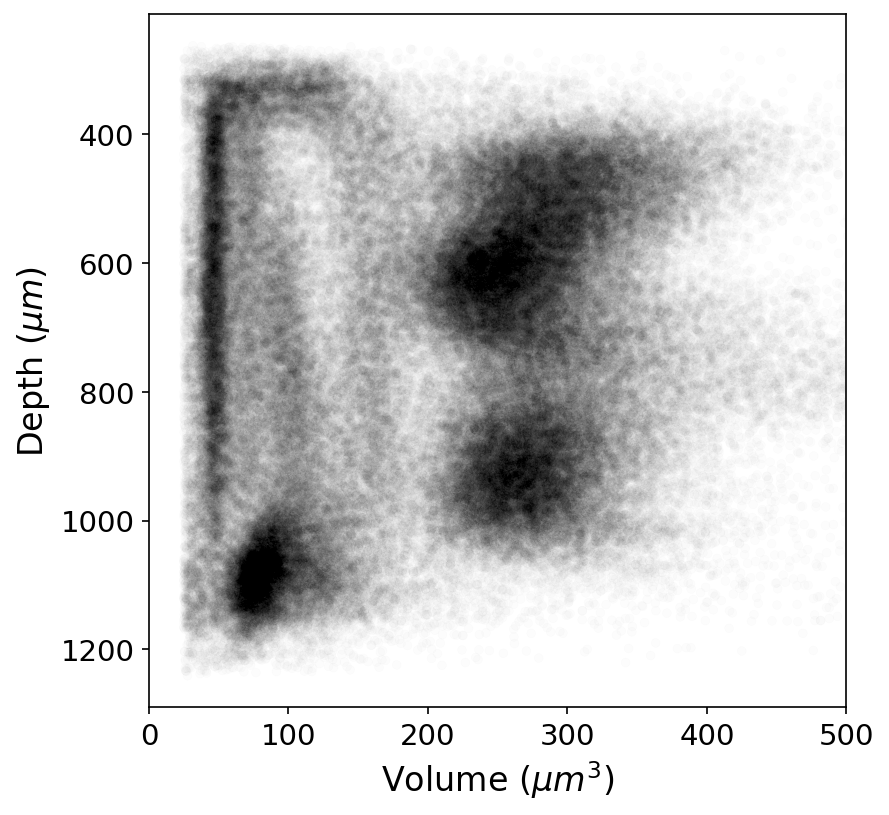

In [11]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=150)
ax.tick_params(labelsize=14)
sns.scatterplot(data=nucleus_df, x="volume", y="pt_position_y", size=1, edgecolor=None, alpha=.01, color="k", ax=ax, legend=False)
ax.invert_yaxis()
ax.set_xlabel("Volume ($\mu m^3$)", fontsize=16)
ax.set_ylabel("Depth ($\mu m$)", fontsize=16)
ax.set_xlim(0, 500)
plt.show()

#### Cell type information 

Identifying the putative ‘cell type’ from the EM morphology is a process that involves both manual and automatic classifications. Subsets of the dataset have been manually classified by anatomists at the Allen Institute, and these ground truth labels used to train and refine different automated ‘feature classifiers’ over time.

The diversity of manual and automated cell type classifications available in the dataset reflect the fact that definitions of ‘cell types’ in the dataset is an active area of research and must be contextualized against the purpose and resolution of the cell-typing being performed.

__Manual Cell Types (V1 Column)__

A subset of nucleus detections in a 100 um column (n=2204) in VISp were manually classified by anatomists at the Allen Institute into categories of cell subclasses, first distinguishing cells into classes of non-neuronal, excitatory and inhibitory. Excitatory cells were separated into laminar sub-classes (L23, L4), 3 sub-types of layer 5 cells (ET, IT, NP) and 2 classes of layer 6 cells (IT, CT). Inhibitory cells were classified into Bipolar (BPC), Basket (BC), Martinotti (MC), or Unsure (Unsure). Those neuronal calls are available from the CAVEclient under the table name `allen_v1_column_types_slanted_ref` which references the nucleus id of the cell.


Non-neuronal manual cells type calls enumerate astrocytes, microglia, pericytes, oligodendrocytes (oligo), and oligodendrocyte precursor cells (OPC), and area available in the table `aibs_column_nonneuronal_ref`.

In [26]:
manual_ct_df = client.materialize.query_table("allen_v1_column_types_slanted_ref", 
                                              desired_resolution=[1000, 1000, 1000], 
                                              split_positions=True,
                                              merge_reference=False)

print(len(manual_ct_df))
manual_ct_df.head(5)

1357


,id,created,superceded_id,valid,target_id,classification_system,cell_type
0,1,2023-03-18 14:13:21.577622+00:00,NaN,t,298945,aibs_coarse_excitatory,5P-IT
1,2,2023-03-18 14:13:21.578408+00:00,NaN,t,294715,aibs_coarse_excitatory,23P
2,3,2023-03-18 14:13:21.579093+00:00,NaN,t,264649,aibs_coarse_inhibitory,MC
3,4,2023-03-18 14:13:21.579790+00:00,NaN,t,294489,aibs_coarse_excitatory,23P
4,5,2023-03-18 14:13:21.580463+00:00,NaN,t,292708,aibs_coarse_excitatory,23P


__Automated Cell Type classification (Soma-nucleus model)__

Models were trained based upon the manual Column Neuron labels, as described in [Elabbady et al. Nature 2025](https://www.nature.com/articles/s41586-024-07765-7). Each nucleus was analyzed for a variety of features, and a model trained on and independent dataset to distinguish neurons from non-neuronal detections. Non-neuron detections include both glial cells and false positive detections. The nucleus segmentation detected 171,818 connected components of nucleus objects, this model detected 82K neurons. Evaluation of this model on 1,316 cells in the volume shows the model has a recall of 99.6% for neurons, and a precision of 96.9%. All nucleus detections and the results of this model can be queried and linked to the cellular segmentation using the CAVEclient with the table name nucleus_neuron_svm.

Combining those features with the nucleus features we trained a hierachical model on the manual labels to predict cell-classes and sub-classes across a large number of neurons. This is available as CAVE table `aibs_metamodel_celltypes_v661`.

In [12]:
ct_df = client.materialize.query_table("aibs_metamodel_celltypes_v661", 
                                       desired_resolution=[1000, 1000, 1000], 
                                       split_positions=True,
                                       merge_reference=False,
                                      )
print(len(ct_df))
ct_df.head(5)

94014


,id,created,superceded_id,valid,target_id,classification_system,cell_type
0,36916,2023-12-19 22:47:18.659864+00:00,NaN,t,336365,excitatory_neuron,5P-IT
1,1070,2023-12-19 22:38:00.472115+00:00,NaN,t,110648,excitatory_neuron,23P
2,1099,2023-12-19 22:38:00.898837+00:00,NaN,t,112071,excitatory_neuron,23P
3,13259,2023-12-19 22:41:14.417986+00:00,NaN,t,197927,nonneuron,oligo
4,13271,2023-12-19 22:41:14.685474+00:00,NaN,t,198087,nonneuron,astrocyte


Reference annotations contain `target_id` to merge them onto the table they target (here: the nucleus table). But do not worry, CAVE automatically merges them onto their target table by default (`merge_reference=True`):

In [13]:
ct_df = client.materialize.query_table("aibs_metamodel_celltypes_v661", 
                                       desired_resolution=[1000, 1000, 1000], 
                                       split_positions=True,
                                       merge_reference=True,
                                       # select_columns=['target_id','pt_root_id','volume','pt_position','cell_type','classification_system']
                                      )

# remove segments with multiple cell bodies
ct_df = ct_df.drop_duplicates("pt_root_id", keep=False)
ct_df.head(5)

,id_ref,created_ref,valid_ref,volume,pt_position_x,pt_position_y,pt_position_z,bb_start_position_x,bb_start_position_y,bb_start_position_z,...,bb_end_position_y,bb_end_position_z,pt_supervoxel_id,pt_root_id,id,created,valid,target_id,classification_system,cell_type
0,336365,2020-09-28 22:42:48.966292+00:00,t,272.488202,839.040,723.328,1083.04,NaN,NaN,NaN,...,NaN,NaN,93606511657924288,864691136274724621,36916,2023-12-19 22:47:18.659864+00:00,t,336365,excitatory_neuron,5P-IT
1,110648,2020-09-28 22:45:09.650639+00:00,t,328.533443,425.792,518.528,1016.40,NaN,NaN,NaN,...,NaN,NaN,79385153184885329,864691135489403194,1070,2023-12-19 22:38:00.472115+00:00,t,110648,excitatory_neuron,23P
2,112071,2020-09-28 22:43:34.088785+00:00,t,272.929423,414.784,597.888,623.32,NaN,NaN,NaN,...,NaN,NaN,79035988248401958,864691136147292311,1099,2023-12-19 22:38:00.898837+00:00,t,112071,excitatory_neuron,23P
3,197927,2020-09-28 22:43:10.652649+00:00,t,91.308851,574.400,744.768,1058.84,NaN,NaN,NaN,...,NaN,NaN,84529699506051734,864691135655940290,13259,2023-12-19 22:41:14.417986+00:00,t,197927,nonneuron,oligo
4,198087,2020-09-28 22:41:36.677186+00:00,t,161.744978,551.808,763.776,1094.44,NaN,NaN,NaN,...,NaN,NaN,83756261929388963,864691135809440972,13271,2023-12-19 22:41:14.685474+00:00,t,198087,nonneuron,astrocyte


The reference table added two additional data columns: `classification_system` and `cell_type`. The `classification_system` divides the cells into excitatitory and inhibitory neurons as well as non-neuronal cells. `cell_type` provides lower level cell annotations.

In [14]:
ct_df["classification_system"].value_counts()

classification_system
excitatory_neuron    63779
nonneuron            18718
inhibitory_neuron     7856
Name: count, dtype: int64

In [15]:
ct_df["cell_type"].value_counts()

cell_type
23P          19647
4P           14723
6P-IT        11640
5P-IT         7892
astrocyte     7111
oligo         6901
6P-CT         6759
BC            3313
MC            2438
microglia     2400
5P-ET         2160
BPC           1484
OPC           1460
5P-NP          958
pericyte       846
NGC            621
Name: count, dtype: int64

#### Location vs depth + Cell type


Because the cell type table contains the information about the nuclei, we can use it to plot the locations of all cell bodies as well and label them by type.

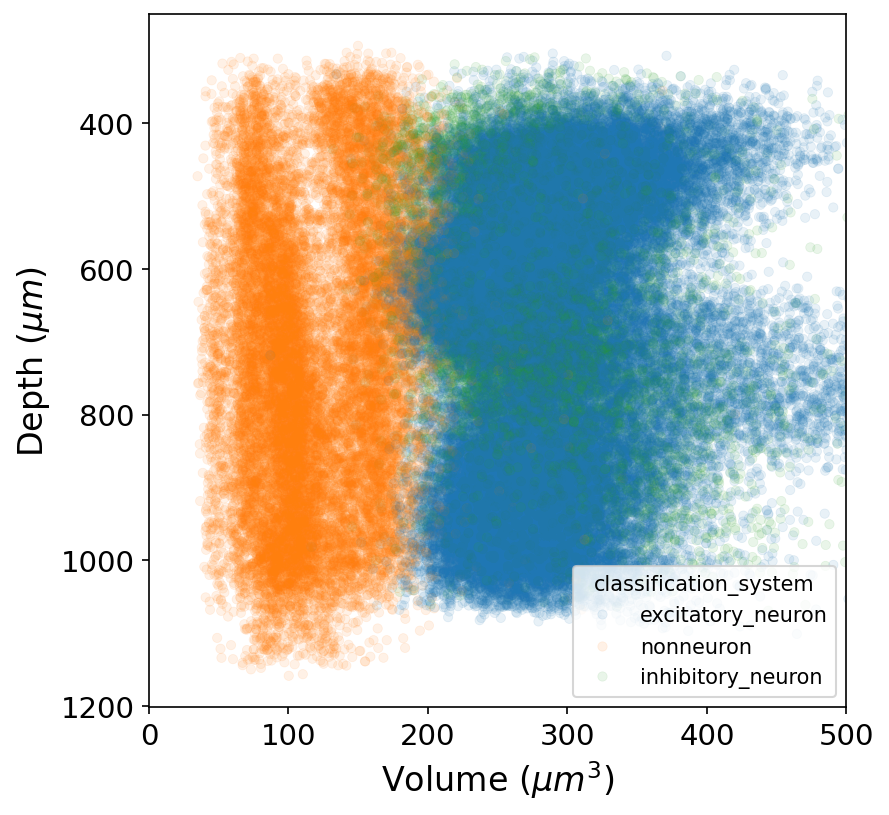

In [16]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=150)
ax.tick_params(labelsize=14)
sns.scatterplot(data=ct_df, x="volume", y="pt_position_y", s=20, edgecolor=None, alpha=.1, color="k", ax=ax, 
                legend=True, hue="classification_system")
ax.invert_yaxis()
ax.set_xlabel("Volume ($\mu m^3$)", fontsize=16)
ax.set_ylabel("Depth ($\mu m$)", fontsize=16)
ax.set_xlim(0, 500)
plt.show()

Soma volume is one of the distinguishing features used to classify cells into their morphological subtypes, and as expected this shows up in the plot of soma size by depth.

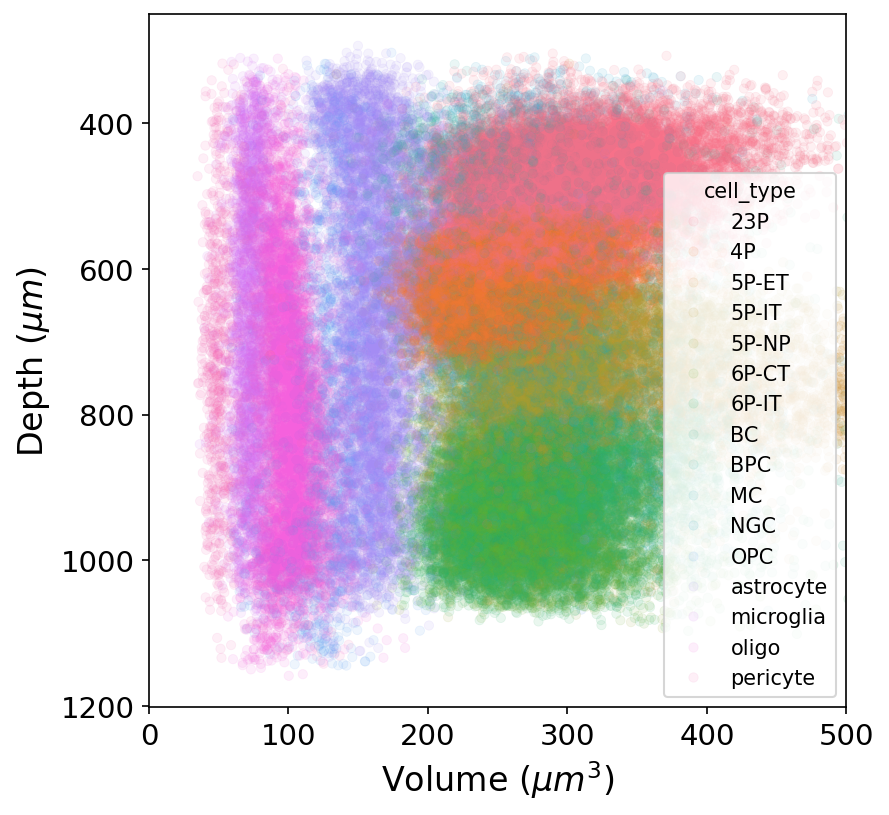

In [17]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=150)
ax.tick_params(labelsize=14)
sns.scatterplot(data=ct_df, x="volume", y="pt_position_y", s=20, edgecolor=None, alpha=.1, color="k", ax=ax, 
                hue_order = ct_df.sort_values('cell_type').cell_type.unique(),
                legend=True, hue="cell_type")
ax.invert_yaxis()
ax.set_xlabel("Volume ($\mu m^3$)", fontsize=16)
ax.set_ylabel("Depth ($\mu m$)", fontsize=16)
ax.set_xlim(0, 500)
plt.show()

### Query 2: synapses and connectivity

While synapses are stored as any other table in the database, in this case `synapses_pni_2`, this table is much larger than any other table at more than 337 million rows:

In [18]:
client.materialize.get_annotation_count('synapses_pni_2')

337312429

While we can query the synapse table directly, this is generally not recommended. It is too large to query all at once. CAVE limits to queries to 500,000 rows at once and will display a warning when that happens. Here, we demonstrate this with the limit set to 10:

In [19]:
synapse_table_name = client.info.get_datastack_info()["synapse_table"]
syn_df = client.materialize.query_table(synapse_table_name, limit=10, desired_resolution=[1, 1, 1], split_positions=True)
syn_df

,id,created,superceded_id,valid,pre_pt_position_x,pre_pt_position_y,pre_pt_position_z,post_pt_position_x,post_pt_position_y,post_pt_position_z,ctr_pt_position_x,ctr_pt_position_y,ctr_pt_position_z,size,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id
0,4456,2020-11-04 13:02:08.388988+00:00,NaN,t,211448.0,409744.0,801440.0,211448.0,409744.0,801440.0,211612.0,410172.0,801400.0,2956,72063160986635724,864691135533713769,72063160986635724,864691135533713769
1,4503,2020-11-04 12:09:33.286834+00:00,NaN,t,212456.0,408032.0,800360.0,212456.0,408032.0,800360.0,212168.0,408088.0,800400.0,344,72063092267156962,864691135087527094,72063092267156962,864691135087527094
2,4508,2020-11-04 13:02:13.024144+00:00,NaN,t,212448.0,411696.0,801440.0,212448.0,411696.0,801440.0,212224.0,411800.0,801560.0,344,72063229706111827,864691135533713769,72063229706111827,864691135533713769
3,4568,2020-11-04 13:44:08.085705+00:00,NaN,t,213392.0,415448.0,802920.0,213392.0,415448.0,802920.0,213096.0,415176.0,802880.0,13816,72133735889250131,864691134530418554,72133735889250131,864691134530418554
4,4581,2020-11-04 07:29:12.917622+00:00,NaN,t,213552.0,417184.0,800800.0,213552.0,417184.0,800800.0,213240.0,417080.0,801080.0,10436,72133804608718799,864691134745062676,72133804608718799,864691134745062676
5,4582,2020-11-04 13:02:17.694701+00:00,NaN,t,212880.0,409120.0,801440.0,212880.0,409120.0,801440.0,213016.0,408832.0,801520.0,1344,72063160986636743,864691135533713769,72063160986636743,864691135533713769
6,4588,2020-11-04 12:20:12.290593+00:00,NaN,t,213200.0,421120.0,805520.0,213200.0,421120.0,805520.0,213064.0,421000.0,805600.0,7128,72133942047682150,864691134609767690,72133942047682150,864691134609767690
7,4590,2020-11-04 13:20:01.875310+00:00,NaN,t,213504.0,406440.0,805160.0,213504.0,406440.0,805160.0,213336.0,406596.0,805200.0,6572,72133461011344162,864691135091400630,72133461011344162,864691135091400630
8,4606,2020-11-04 07:24:39.038223+00:00,NaN,t,213384.0,413792.0,800800.0,213384.0,413792.0,800800.0,213256.0,413976.0,801040.0,2100,72133667169766499,864691134609872906,72133667169766499,864691134609872906
9,4611,2020-11-04 07:24:37.800341+00:00,NaN,t,213336.0,415304.0,800960.0,213336.0,415304.0,800960.0,213192.0,415604.0,800960.0,492,72133735889243887,864691134609872906,72133735889243887,864691134609872906


Instead, you have several options for querying cells of interest:

* Specifying the `pre_ids`
* Specifying the `post_ids`
* Searching within a `bounding_box`
* Using a combination of the above to iterate through large numbers of neurons


#### Query synapses given `pt_root_id` of interest

The `synapse_query` function allows you to query the synapse table in a more convenient way than most other tables.
In particular, the `pre_ids` and `post_ids` let you specify which root id (or collection of root ids) you want to query, with pre_ids indicating the collection of **presynaptic neurons** and post_ids the collection of **postsynaptic neurons**.

Using both `pre_ids` and `post_ids` in one call is effectively a logical AND, returning only those synapses from neurons in the list of `pre_ids` that target neurons in the list of `post_ids`.

Let's look at our example cell from before:

In [20]:
# Pick example cell
root_id = 864691135572530981

# Query synapse table with synapse_query()
input_syn_df = client.materialize.synapse_query(post_ids=root_id)

print(f"Total number of input synapses for {root_id}: {len(input_syn_df)}")
input_syn_df.head()

Total number of input synapses for 864691135572530981: 7135


,id,created,superceded_id,valid,size,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,pre_pt_position,post_pt_position,ctr_pt_position
0,456611088,2020-11-04 06:48:59.326085+00:00,NaN,t,5140,113239596703504810,864691135479280180,113239596703516355,864691135572530981,"[352662, 182250, 21256]","[352700, 182240, 21263]","[352668, 182240, 21257]"
1,460786295,2020-11-04 06:48:58.480065+00:00,NaN,t,1904,114084296310348680,864691135346964338,114084365029814954,864691135572530981,"[358746, 184452, 19859]","[358872, 184530, 19853]","[358806, 184464, 19860]"
2,461382317,2020-11-04 06:49:11.546047+00:00,NaN,t,424,114016607357442246,864691136359281271,114016607357447165,864691135572530981,"[358370, 204474, 17891]","[358422, 204472, 17897]","[358376, 204448, 17898]"
3,415745273,2020-11-04 06:48:59.036865+00:00,NaN,t,14532,110214290325399938,864691135761573174,110214290325398722,864691135572530981,"[330584, 186192, 20184]","[330508, 186140, 20186]","[330530, 186164, 20184]"
4,426387189,2020-11-04 06:49:11.336675+00:00,NaN,t,3820,111201583316244695,864691135001918174,111201583316238949,864691135572530981,"[337672, 202162, 22387]","[337760, 202146, 22378]","[337716, 202221, 22381]"


Getting the outputs of the cell is similar, except we use the argument `pre_ids`

In [21]:
# Query synapse table with synapse_query()
output_syn_df = client.materialize.synapse_query(pre_ids=root_id)

print(f"Total number of output synapses for {root_id}: {len(output_syn_df)}")
output_syn_df.head()

Total number of output synapses for 864691135572530981: 443


,id,created,superceded_id,valid,size,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,pre_pt_position,post_pt_position,ctr_pt_position
0,395248437,2020-11-04 06:48:59.876707+00:00,NaN,t,9532,108524685221986350,864691135572530981,108524685221977287,864691135490110266,"[318184, 180454, 25315]","[318286, 180522, 25305]","[318246, 180518, 25311]"
1,440616430,2020-11-04 06:49:10.903020+00:00,NaN,t,4432,112185646021939898,864691135572530981,112185646021939884,864691134992343215,"[344966, 194038, 20972]","[344942, 194054, 20975]","[344934, 194048, 20971]"
2,439592768,2020-11-04 06:49:11.156743+00:00,NaN,t,576,112183034412923018,864691135572530981,112183034412912746,864691136423679279,"[344800, 174436, 18504]","[344704, 174410, 18491]","[344778, 174374, 18497]"
3,454114788,2020-11-04 06:49:46.278849+00:00,NaN,t,2356,113309415020761559,864691135572530981,113379783764920953,864691135043239167,"[353300, 178366, 16119]","[353334, 178320, 16124]","[353326, 178320, 16120]"
4,429055494,2020-11-04 06:53:24.912290+00:00,NaN,t,16296,110989034444418846,864691135572530981,110989034444425675,864691135774556861,"[336166, 191682, 25914]","[336260, 191558, 25917]","[336184, 191638, 25915]"


#### Overlay synapses on skeleton

Because these measures come from the same physical space, we can overlay the **skeleton** and the **synapses** of a neuron. Knowing where the synapses are along the **branches of a dendrite or axon** is a common features used for analysis.

More about operating on the arbor of a neuron skeleton is available from the [Skeleton and Mesh Tutorials](https://tutorial.microns-explorer.org/quickstart_notebooks/07-cave-download-skeleton.html)

In [24]:
# select the example cell from neuroglancer
root_id = 864691135572530981

# Query the skeleton from CAVEclient
sk_d = client.skeleton.get_skeleton(root_id, output_format="dict")

# Query synapse table with synapse_query()
output_syn_df = client.materialize.synapse_query(pre_ids=root_id,
                                                split_positions=True,
                                                desired_resolution=[1,1,1] # same resolution as the skeleton
                                                )

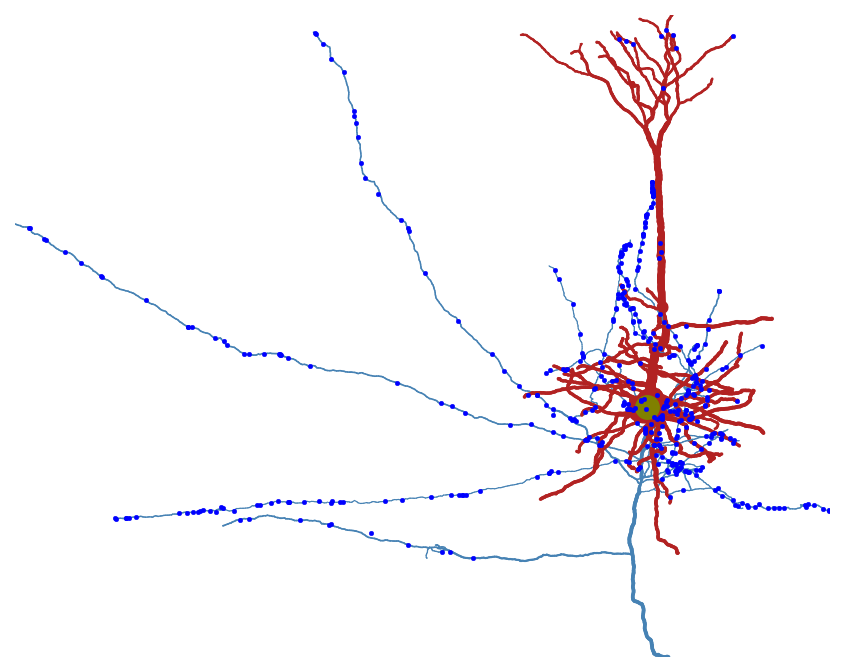

In [25]:
# Plot your skeleton and overlay synapses
ax = plot_skeleton(sk_d)

sns.scatterplot(
    data=output_syn_df,
    x="ctr_pt_position_x",
    y="ctr_pt_position_y",
    s=5,
    color="b",
    ax=ax,
    edgecolor=None,
    zorder=100,
)

plt.show()

Note that synapse queries always return the list of every synapse between the neurons in the query, even if there are multiple synapses between the same pair of neurons.

A common pattern to generate a list of connections between unique pairs of neurons is to group by the root ids of the presynaptic and postsynaptic neurons and then count the number of synapses between them.
For example, use `pandas.groupby()` to get the number of synapses from this neuron onto every other neuron:

In [26]:
# get count of synapses between presynaptic and postsynaptic partners
output_connectivity = (output_syn_df.groupby(['pre_pt_root_id', 'post_pt_root_id'])
 .count()[['id']]
 .rename(columns={'id': 'syn_count'})
 .sort_values( by='syn_count', ascending=False,)
)

output_connectivity
# Note that the 'id' part here is just a way to quickly extract one column. This could be any of the remaining column names, 
# but `id` is often convenient because it is common to all tables.

syn_count
pre_pt_root_id     post_pt_root_id              
864691135572530981 864691136051830771         12
                   864691135918652336          7
                   864691135468408402          5
                   864691136741629020          5
                   864691135593547307          4
...                                          ...
                   864691135099029792          1
                   864691135104996429          1
                   864691135105068365          1
                   864691135105867085          1
                   864691132996824904          1

[368 rows x 1 columns]

#### Plot output target distribution

Taking this connectivity information from one neuron, **quantify the synapses it makes onto all cell types**. This is the same process that happens to make the Dash App plots.

Note: here we work with only *unique* connections, even where there is more than one synapse between them

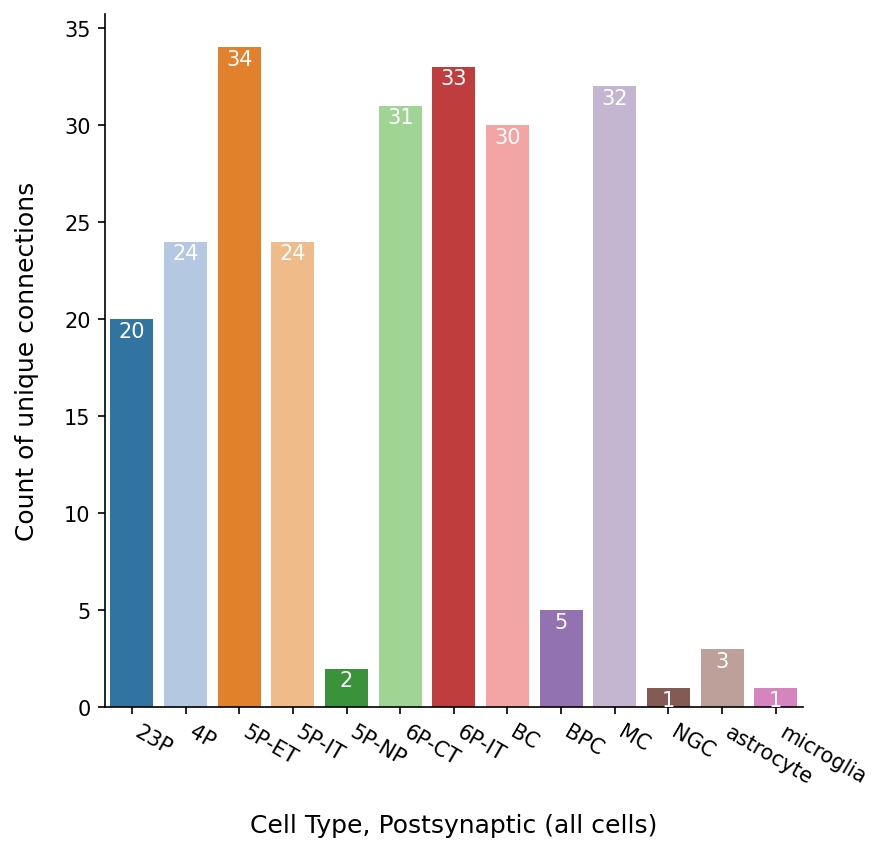

In [55]:
# First, find the unique postsynaptic partners
unique_postsyn_partners = output_syn_df.post_pt_root_id.unique()

# Select the cell types of the postsynaptic partners
ct_postsyn_partners = ct_df.loc[ct_df.pt_root_id.isin(unique_postsyn_partners)]

# Make a bar plot of the connections to the postsynaptic cell types
ct_summary = (pd.DataFrame(ct_postsyn_partners.value_counts('cell_type'))
              .sort_values('cell_type')
              .reset_index()
             )

f, ax = plt.subplots(1,1, figsize=(6, 6),dpi=150)
sns.barplot(ct_summary, x='cell_type', y='count', hue='cell_type', palette='tab20', ax=ax)
    
# Add labels to the bars
for i, r in ct_summary.iterrows():
    ax.text(i, r['count']-.1, round(r['count'], 2), 
            color='white', ha='center', va='top')

plt.ylabel('Count of unique connections', fontsize = 12, labelpad=12) 
plt.xlabel('Cell Type, Postsynaptic (all cells)', fontsize = 12, labelpad=12) 
plt.xticks(rotation=-30, ha='left')

sns.despine()

plt.show()

### Query 3: Proofread connectivity

Proofreading is necessary to obtain accurate reconstructions of a cell. In the MICrONS dataset, the general rule is that dendrites onto cells with a _single_ cell body are sufficiently proofread to trust synaptic connections onto a cell. Axons on the other hand require so much proofreading that only ~1800 cells have axons such that their outputs should be used for analysis.

For more about proofreading, versioning, and other important information, see: [Proofreading and Data Quality](https://tutorial.microns-explorer.org/proofreading.html). For today we will treat all axons that are at least 'axon_partially_extended` as equally trustworthy. This may not be the best choice depdending on the specfici analysis. Reach out to Bethanny with questions for more.

This information is available in the CAVE table: `proofreading_status_and_strategy`


In [28]:
proof_all_df = client.materialize.query_table("proofreading_status_and_strategy")

In [29]:
proof_all_df["strategy_axon"].value_counts()

strategy_axon
axon_partially_extended    1750
axon_fully_extended         267
axon_interareal             124
none                         41
Name: count, dtype: int64

### Filtering Queries by proofreading status
We can filter our query to only return rows that match a condition by adding a filter to our query:

In [30]:
proof_axon_df = client.materialize.query_table("proofreading_status_and_strategy", 
                                               filter_in_dict={"strategy_axon": ["axon_partially_extended", "axon_fully_extended", "axon_interareal"]}, 
                                               desired_resolution=[1, 1, 1], 
                                               split_positions=True)
proof_axon_df.tail()

,id,created,superceded_id,valid,pt_position_x,pt_position_y,pt_position_z,valid_id,status_dendrite,status_axon,strategy_dendrite,strategy_axon,pt_supervoxel_id,pt_root_id
2136,4002,2025-07-22 18:26:32.791280+00:00,NaN,t,703680.0,416064.0,907280.0,864691135783113040,t,t,dendrite_extended,axon_fully_extended,88951866083486311,864691135783113040
2137,3969,2025-07-22 18:26:32.196312+00:00,NaN,t,685568.0,697920.0,931040.0,864691136313908797,t,t,dendrite_extended,axon_fully_extended,88328030740880370,864691135928941780
2138,4003,2025-07-22 18:26:32.804932+00:00,NaN,t,638976.0,477440.0,867480.0,864691135493371743,t,t,dendrite_extended,axon_fully_extended,86702127719919273,864691135442616392
2139,3951,2025-07-22 18:26:31.880460+00:00,NaN,t,729600.0,551424.0,922920.0,864691135398557473,t,t,dendrite_extended,axon_fully_extended,89871195310210159,864691135360909656
2140,3999,2025-07-22 18:26:32.748278+00:00,NaN,t,801024.0,834304.0,879280.0,864691135271848613,t,t,dendrite_extended,axon_fully_extended,92343584443356753,864691135389004929


A more unified filter interface is available through a "table manager" interface.

Rather than passing a table name to the `query_table` function, `client.materialize.tables` has a subproperty for each table in the database that can be used to filter that table.

The general pattern for usage is

``` python
client.materialize.tables.{table_name}({filter options}).query({format and timestamp options})
```

where `{table_name}` is the name of the table you want to filter, `{filter options}` is a collection of arguments for filtering the query, and `{format and timestamp options}` are those parameters controlling the format and timestamp of the query.

With this, we can easily query all proofread cells with proofread axons:

In [31]:
proof_axon_df = client.materialize.tables.proofreading_status_and_strategy(strategy_axon=["axon_partially_extended", "axon_fully_extended", "axon_interareal"]).query(
    select_columns=['pt_root_id','status_axon','status_dendrite','strategy_axon','strategy_dendrite'],
)
proof_axon_df.tail()

,pt_root_id,status_axon,status_dendrite,strategy_axon,strategy_dendrite
2136,864691135783113040,t,t,axon_fully_extended,dendrite_extended
2137,864691135928941780,t,t,axon_fully_extended,dendrite_extended
2138,864691135442616392,t,t,axon_fully_extended,dendrite_extended
2139,864691135360909656,t,t,axon_fully_extended,dendrite_extended
2140,864691135389004929,t,t,axon_fully_extended,dendrite_extended


#### Collect synapses between proofread cells. 

We can now collect the synapses between a proofread cells to form a 'connectivity matrix', or the known connections from one cell to every other cell. 

In its square form, a **closed set**, this is connectivity forms an Adjacency Matrix, or a graph representation of the network connectivity. Here we look at the connectivity between proofread excitatory neurons.

In [36]:
# Collect the list of root ids that are proofread and have a cell type
exc_ct_df = ct_df.query("classification_system=='excitatory_neuron'")

proofread_exc_ids = exc_ct_df.loc[exc_ct_df.pt_root_id.isin(proof_axon_df.pt_root_id.values), 'pt_root_id'].values
len(proofread_exc_ids)

1740

In [38]:
%%time

# Collect all synapses between proofread cells. This may take several minutes to run
proof_proof_syn_df = client.materialize.synapse_query(
    pre_ids=proofread_exc_ids,
    post_ids=proofread_exc_ids,
)
print(len(proof_proof_syn_df))

CPU times: total: 500 ms
Wall time: 1min 21s


This gives us the 'long' version of the synapse table, where every row is a synapse. Now we will `pivot` this table into a square form, where both rows and columns are unique cells that form connections. 

In [43]:
# pivot the synapse table
syn_mat = proof_proof_syn_df.pivot_table(index="pre_pt_root_id", 
                                         columns="post_pt_root_id",
                                         values="size", 
                                         aggfunc=lambda x: float(np.sum(x) > 0)).fillna(0)
syn_mat = syn_mat.reindex(columns=np.array(syn_mat.index))

This gives us a sparse matrix that is mostly zeros, which we can visualize as a connectivity heatmap

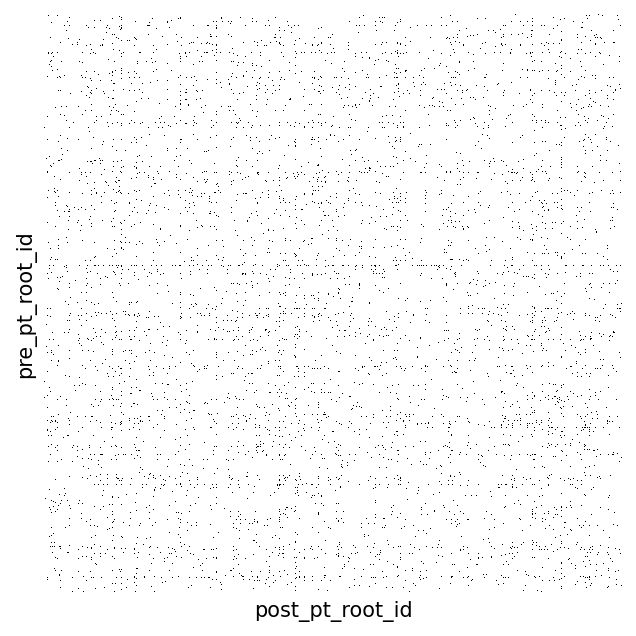

In [48]:
fig, ax = plt.subplots(figsize=(7, 5), dpi=150)
sns.heatmap(syn_mat, cmap="gray_r", 
            xticklabels=[], yticklabels=[], cbar=None,
            ax=ax, 
            square=True,
           )
plt.show()


#### Sort synapse matrix with cell types
Let’s combine the synaptic connecitivity with the cell type information. Below we provide logic for sorting a connectivity matrix using a list of labels.

In [49]:
def sort_matrix_by_types(mat: pd.DataFrame, 
                         labels: pd.DataFrame, 
                         label_type_col: str = "cell_type", 
                         label_id_col: str = "pt_root_id", 
                         post_labels: pd.DataFrame = None, 
                         post_label_type_col: str = None, 
                         post_label_id_col: str = None):
    """Sorts (synapse) matrix by labels.

    This function assumes a square synapse matrix!

    Args:
        mat: synapse matrix as pandas DataFrame
        labels: DataFrame with labels, e.g. the output of client.materialize.query_table('aibs_metamodel_celltypes_v661')
        label_type_col: column name in labels for cell types
        label_id_col: column name in labels for root ids
        post_labels: DataFrame with labels, e.g. the output of client.materialize.query_table('aibs_metamodel_celltypes_v661')
        post_label_type_col: column name in labels for cell types
        post_label_id_col: column name in labels for root ids

    Returns:
        mat_sorted: sorted matrix
        mat_labels: sorted labels; has the same length as matrix
    """
    
    if post_labels is None:
        post_labels = labels
    if post_label_type_col is None:
        post_label_type_col = label_type_col
    if post_label_id_col is None:
        post_label_id_col = label_id_col
        
    mat_sorted = mat.copy()
    
    pre_mat_labels = np.array(labels.set_index(label_id_col).loc[mat_sorted.index][label_type_col])
    pre_sorting = np.argsort(pre_mat_labels)

    post_mat_labels = np.array(post_labels.set_index(post_label_id_col).loc[mat_sorted.T.index][post_label_type_col])
    post_sorting = np.argsort(post_mat_labels)

    mat_sorted = mat_sorted.iloc[pre_sorting].T.iloc[post_sorting].T

    return mat_sorted, pre_mat_labels[pre_sorting], post_mat_labels[post_sorting]

In [51]:
# sort the matrix by cell types to render sensibly in heatmap
syn_mat_ct, syn_mat_cell_types, _ = sort_matrix_by_types(syn_mat, exc_ct_df, label_type_col="cell_type")

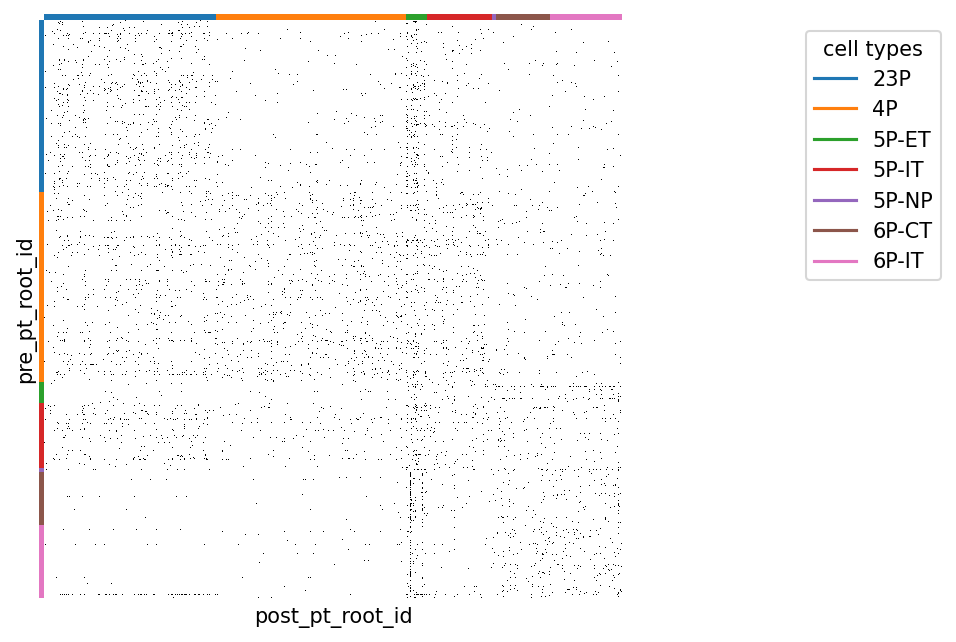

In [54]:
import matplotlib

# add colormap for cell type
cts, ct_idx = np.unique(syn_mat_cell_types, return_inverse=True)
ct_colors = plt.get_cmap("tab10")(ct_idx)

fig, ax = plt.subplots(figsize=(7, 5), dpi=150)
sns.heatmap(syn_mat_ct, cmap="gray_r", xticklabels=[], yticklabels=[], 
            ax=ax, square=True,
            cbar=None)


# Adding row and column colors for cell types
for i, color in enumerate(ct_colors):
    ax.add_patch(plt.Rectangle(xy=(-0.01, i), width=0.01, height=1, color=color, lw=0,
                               transform=ax.get_yaxis_transform(), clip_on=False))

for i, color in enumerate(ct_colors):
    ax.add_patch(plt.Rectangle(xy=(i, 1), height=0.01, width=1, color=color, lw=0,
                               transform=ax.get_xaxis_transform(), clip_on=False))

# add a legend for the cell types
legend_elements = [matplotlib.lines.Line2D([0], [0], color=plt.get_cmap("tab10")(i), label=ct) for i, ct in enumerate(cts)]
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.3, 1), title="cell types")
plt.show()

# Advanced Neuroglancer

You can actually overlay many of these properties in neuroglancer, including:

* Skeletons: https://spelunker.cave-explorer.org/#!middleauth+https://global.daf-apis.com/nglstate/api/v1/6025750544121856 
* Nucleus segmentation: https://spelunker.cave-explorer.org/#!middleauth+https://global.daf-apis.com/nglstate/api/v1/4846103861133312 
* Cell Types: https://spelunker.cave-explorer.org/#!middleauth+https://global.daf-apis.com/nglstate/api/v1/5505896963637248
* Proofreading Status: https://spelunker.cave-explorer.org/#!middleauth+https://global.daf-apis.com/nglstate/api/v1/5626062229733376
* Synapses: https://spelunker.cave-explorer.org/#!middleauth+https://global.daf-apis.com/nglstate/api/v1/6395755509055488

And any combination thereof. Tip: drag layers between diferent neuroglancer windows to view overlaid

